Option to improve:
- Add different variables (maybe quality of life/health-quality from the QLC-Q30 list)
- Improve data imputation for the categorical variables (look into this)
- Ask Katrijn + Consider how to deal with the variables for which there is no data available depending on the source 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

#Data imputation MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import random
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

pd.set_option('display.max_columns', None)

In [3]:
pred_data = pd.read_csv("prediction_data.csv")


<Axes: xlabel='clusters'>

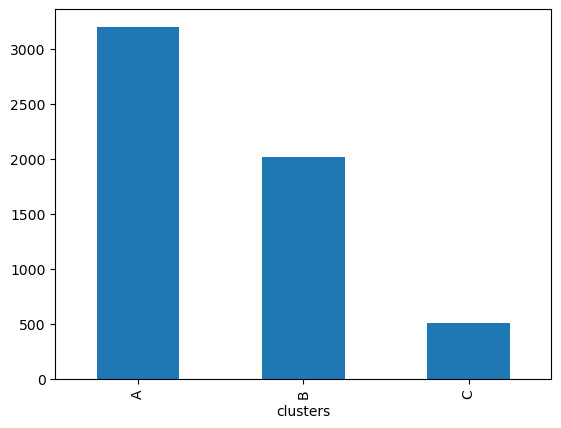

In [4]:
#Example of class imbalance. 
pred_data.pivot_table(index='clusters', aggfunc='size').plot(kind='bar')

In [5]:
pred_data = pred_data.drop(columns=['Unnamed: 0', 'age_questionnaire', 'Age_questionnaire_cat', 'age_diagnosis', "time_diagnosis"]) 

pred_data = pred_data.drop(pred_data.columns[9:53], axis=1)
pred_data = pred_data.drop(columns=['stage_annarbor', 'chemotherapy', 'hormonetherapy', 'targetedtherapy', 'stemcell', "watchfulwaiting", 'watchfullwaiting', 'Bladderspecifictreatments', "bladdersubtype", "Financial impact of disease"]) 

In [6]:
pred_data.head(5)

participant_id clusters   source  wave  education  partner  smoking  \
0               1        A  procore     1        1.0      1.0      2.0   
1               1        A  procore     2        1.0      NaN      NaN   
2               1        A  procore     3        1.0      1.0      2.0   
3               1        A  procore     4        1.0      1.0      2.0   
4               2        A  procore     1        3.0      1.0      1.0   

   alcoholuse  comorbidities  tumortype  stage_tnm  radiotherapy  \
0         1.0            1.0        7.0        1.0           0.0   
1         NaN            NaN        7.0        1.0           0.0   
2         1.0            1.0        7.0        1.0           0.0   
3         1.0            1.0        7.0        1.0           0.0   
4         1.0            1.0        7.0        2.0           0.0   

   Age_diagnosis_cat    bmi  surgery  systemic  sex  
0               13.0  25.83      1.0       0.0    1  
1               13.0    NaN      1.0       0.0    1  
2               13.0  23.30      1.0       0.0    1  
3               13.0    NaN      1.0       0.0    1  
4               11.0  24.09      1.0       0.0    2

In [7]:
pred_data = pred_data.assign(participant_id_copy = lambda x : x['participant_id'] ).sort_values(by = ['participant_id_copy', 'wave']).groupby(['participant_id_copy'], group_keys=False).fillna(method='bfill')
pred_data = pred_data.loc[pred_data["wave"] == 1]

In [8]:
pred_data.isna().sum()

participant_id         0
clusters               8
source                 0
wave                   0
education              4
partner              781
smoking                0
alcoholuse             2
comorbidities         22
tumortype              0
stage_tnm             10
radiotherapy         973
Age_diagnosis_cat      0
bmi                   12
surgery              766
systemic             331
sex                    0
dtype: int64

### Patient characteristics
There is just very little difference between the patients, this may cause the prediction to perform very poorly. 

In [9]:
pred_data[pred_data["clusters"] == "A"].describe()

participant_id   wave   education     partner     smoking  alcoholuse  \
count      807.000000  807.0  805.000000  339.000000  807.000000  807.000000   
mean      2091.835192    1.0    2.843478    1.371681    1.873606    2.654275   
std       1121.300729    0.0    0.910332    0.483968    0.584230    0.720613   
min          1.000000    1.0    1.000000    1.000000    1.000000    1.000000   
25%       1650.500000    1.0    2.000000    1.000000    2.000000    3.000000   
50%       2402.000000    1.0    3.000000    1.000000    2.000000    3.000000   
75%       2981.000000    1.0    4.000000    2.000000    2.000000    3.000000   
max       3504.000000    1.0    4.000000    2.000000    3.000000    3.000000   

       comorbidities   tumortype   stage_tnm  radiotherapy  Age_diagnosis_cat  \
count     800.000000  807.000000  805.000000    249.000000         807.000000   
mean        1.071250    8.339529    1.585093      0.164659          12.758364   
std         0.818236    1.093046    0.834145      0.371619           9.259016   
min         0.000000    5.000000    1.000000      0.000000           1.000000   
25%         0.000000    8.000000    1.000000      0.000000          11.000000   
50%         1.000000    9.000000    1.000000      0.000000          13.000000   
75%         2.000000    9.000000    2.000000      0.000000          14.000000   
max         2.000000    9.000000    4.000000      1.000000         197.000000   

              bmi  surgery    systemic         sex  
count  800.000000    361.0  636.000000  807.000000  
mean    26.486887      1.0    0.712264    1.242875  
std      3.756365      0.0    0.453064    0.429086  
min     16.070000      1.0    0.000000    1.000000  
25%     23.990000      1.0    0.000000    1.000000  
50%     25.975000      1.0    1.000000    1.000000  
75%     28.570000      1.0    1.000000    1.000000  
max     45.700000      1.0    1.000000    2.000000

In [10]:
pred_data[pred_data["clusters"] == "B"].describe()

participant_id   wave   education     partner     smoking  alcoholuse  \
count      512.000000  512.0  511.000000  251.000000  512.000000  510.000000   
mean      2110.964844    1.0    2.700587    1.406375    1.917969    2.547059   
std       1047.587380    0.0    0.910925    0.492137    0.604217    0.790875   
min         13.000000    1.0    1.000000    1.000000    1.000000    1.000000   
25%       1658.750000    1.0    2.000000    1.000000    2.000000    2.000000   
50%       2346.500000    1.0    3.000000    1.000000    2.000000    3.000000   
75%       2945.500000    1.0    3.000000    2.000000    2.000000    3.000000   
max       3505.000000    1.0    4.000000    2.000000    3.000000    3.000000   

       comorbidities   tumortype   stage_tnm  radiotherapy  Age_diagnosis_cat  \
count     504.000000  512.000000  506.000000    176.000000         512.000000   
mean        1.426587    8.156250    1.664032      0.153409          12.556641   
std         0.779054    1.289351    0.884280      0.361410           8.321142   
min         0.000000    5.000000    1.000000      0.000000           1.000000   
25%         1.000000    7.000000    1.000000      0.000000          11.000000   
50%         2.000000    9.000000    1.000000      0.000000          12.000000   
75%         2.000000    9.000000    2.000000      0.000000          14.000000   
max         2.000000    9.000000    4.000000      1.000000         194.000000   

              bmi     surgery    systemic         sex  
count  508.000000  256.000000  389.000000  512.000000  
mean    27.151929    0.996094    0.686375    1.392578  
std      5.955909    0.062500    0.464563    0.488802  
min     14.450000    0.000000    0.000000    1.000000  
25%     24.020000    1.000000    0.000000    1.000000  
50%     26.300000    1.000000    1.000000    1.000000  
75%     29.330000    1.000000    1.000000    2.000000  
max    101.230000    1.000000    1.000000    2.000000

In [11]:
pred_data[pred_data["clusters"] == "C"].describe()

participant_id   wave   education    partner     smoking  alcoholuse  \
count      129.000000  129.0  128.000000  80.000000  129.000000  129.000000   
mean      2062.023256    1.0    2.281250   1.437500    1.945736    2.364341   
std       1055.238054    0.0    0.831823   0.499208    0.710524    0.847220   
min         40.000000    1.0    1.000000   1.000000    1.000000    1.000000   
25%       1723.000000    1.0    2.000000   1.000000    1.000000    2.000000   
50%       2200.000000    1.0    2.000000   1.000000    2.000000    3.000000   
75%       2959.000000    1.0    3.000000   2.000000    2.000000    3.000000   
max       3487.000000    1.0    4.000000   2.000000    3.000000    3.000000   

       comorbidities   tumortype   stage_tnm  radiotherapy  Age_diagnosis_cat  \
count     124.000000  129.000000  128.000000     55.000000         129.000000   
mean        1.524194    7.852713    1.820312      0.163636          12.217054   
std         0.748589    1.479552    0.999477      0.373355           2.325004   
min         0.000000    5.000000    1.000000      0.000000           5.000000   
25%         1.000000    7.000000    1.000000      0.000000          10.000000   
50%         2.000000    9.000000    1.000000      0.000000          13.000000   
75%         2.000000    9.000000    3.000000      0.000000          14.000000   
max         2.000000    9.000000    4.000000      1.000000          16.000000   

              bmi    surgery   systemic         sex  
count  129.000000  70.000000  95.000000  129.000000  
mean    26.706434   0.957143   0.642105    1.527132  
std      5.252967   0.203997   0.481924    0.501210  
min     14.710000   0.000000   0.000000    1.000000  
25%     23.440000   1.000000   0.000000    1.000000  
50%     25.730000   1.000000   1.000000    2.000000  
75%     29.340000   1.000000   1.000000    2.000000  
max     46.060000   1.000000   1.000000    2.000000

### Work

In [12]:
for column in pred_data.columns:
    if len(pred_data[column].unique()) > 20:
        continue
    else: 
         print(column, pred_data[column].unique())

clusters ['A' 'B' 'C' nan]
source ['procore' 'rogy' 'blazib']
wave [1]
education [ 1.  3.  2.  4. nan]
partner [ 1.  2. nan]
smoking [2. 1. 3.]
alcoholuse [ 1.  3.  2. nan]
comorbidities [ 1.  2.  0. nan]
tumortype [7. 8. 6. 5. 9.]
stage_tnm [ 1.  2.  3.  4. nan]
radiotherapy [ 0.  1. nan]
Age_diagnosis_cat [ 13.  11.  14.  10.  15.  12.   1.   9.   7.   8.  16.  17. 194. 191.
   5. 197.]
surgery [ 1. nan  0.]
systemic [ 0.  1. nan]
sex [1 2]


### Checking data discrepancies per source

This will be editted in the following way: 
- When a question is not asked in the other we will change the data NaN data into "method not applicable". We do this to avoid filling in "0 (not received) for certain treatment methods,
because this would mean people did not get a type of treatment, but this is not true. The reality is that this treatment is not suitable for this sickness. 
- For the NaN values where the question was in the actual survey we fill it in with a 0, to indicate treatment was not received; the idea behind is that generally when someone received a type of treat-
ment they would fill this in. Also, this won't be too impactfull as there is just very few of such values.  

## Data transformation
Removing values that are non-sensible

#### Imputation
- Value counts to assess how to deal with the value 
- Simple imputation for comorbidities
- MICE imputation for BMI
- 

In [13]:
pred_df = pred_data.copy(deep=True)
pred_df = pred_df[pred_df["clusters"].notna()] #Remove the rows for which no cluster was found. 

In [14]:
pred_df.isna().sum()

participant_id         0
clusters               0
source                 0
wave                   0
education              4
partner              778
smoking                0
alcoholuse             2
comorbidities         20
tumortype              0
stage_tnm              9
radiotherapy         968
Age_diagnosis_cat      0
bmi                   11
surgery              761
systemic             328
sex                    0
dtype: int64

In [15]:
#Function to impute by most frequent
def fillwithmostfrequent(column):
    imputer = SimpleImputer(strategy='most_frequent')

    comorbidity_values = column.values
    comorbidity_values = comorbidity_values.reshape(-1,1)
    comorbidity_values = imputer.fit_transform(comorbidity_values)
    column = comorbidity_values
    return column

pred_df["education"] = fillwithmostfrequent(pred_df["education"])
pred_df["stage_tnm"] = fillwithmostfrequent(pred_df["stage_tnm"])
pred_df["alcoholuse"] = fillwithmostfrequent(pred_df["alcoholuse"])
pred_df["comorbidities"] = fillwithmostfrequent(pred_df["comorbidities"])

In [16]:
pred_df.loc[(pred_df["source"] == "blazib", "partner")] = pred_df.loc[(pred_df["source"] == "blazib", "partner")].fillna("Question not asked")
pred_df.loc[(pred_df["source"] == "blazib", "radiotherapy")] = pred_df.loc[(pred_df["source"] == "blazib", "radiotherapy")].fillna("Question not asked")
pred_df.loc[(pred_df["source"] == "blazib", "surgery")] = pred_df.loc[(pred_df["source"] == "blazib", "surgery")].fillna(0)
pred_df.loc[(pred_df["source"] == "blazib", "systemic")] = pred_df.loc[(pred_df["source"] == "blazib", "surgery")].fillna(0)

#Normalize BMI
pred_df["bmi"] = (pred_df["bmi"]-pred_df["bmi"].min())/(pred_df["bmi"].max()-pred_df["bmi"].min())

In [17]:
#Still have to fix this 
pred_df = pred_df.loc[pred_df["Age_diagnosis_cat"] < 20]

In [18]:
imputer = SimpleImputer(strategy='mean')

comorbidity_values = pred_df["bmi"].values
comorbidity_values = comorbidity_values.reshape(-1,1)
comorbidity_values = imputer.fit_transform(comorbidity_values)
pred_df["bmi"] = comorbidity_values

In [19]:
pred_df.drop(columns=['source', 'wave', 'participant_id'], inplace=True) 

In [20]:
#Turn everything into dummies
pred_df = pd.get_dummies(pred_df, columns=['partner', 'tumortype', 'radiotherapy','surgery', 'systemic', 'sex'])

#Variables that are inherently label encoded: 'Age_diagnosis_cat', 'smoking', 'education', 'alcoholuse', 'comorbidities', 'stage_tnm',


In [21]:
pred_df.head()

clusters  education  smoking  alcoholuse  comorbidities  stage_tnm  \
0         A        1.0      2.0         1.0            1.0        1.0   
4         A        3.0      1.0         1.0            1.0        2.0   
8         A        2.0      2.0         3.0            2.0        2.0   
12        A        2.0      3.0         3.0            2.0        1.0   
16        A        4.0      2.0         3.0            2.0        3.0   

    Age_diagnosis_cat       bmi  partner_1.0  partner_2.0  \
0                13.0  0.131136            1            0   
4                11.0  0.111086            1            0   
8                11.0  0.184720            1            0   
12               13.0  0.153492            0            1   
16               14.0  0.140470            1            0   

    partner_Question not asked  tumortype_5.0  tumortype_6.0  tumortype_7.0  \
0                            0              0              0              1   
4                            0              0              0              1   
8                            0              0              0              1   
12                           0              0              0              1   
16                           0              0              0              1   

    tumortype_8.0  tumortype_9.0  radiotherapy_0.0  radiotherapy_1.0  \
0               0              0                 1                 0   
4               0              0                 1                 0   
8               0              0                 1                 0   
12              0              0                 1                 0   
16              0              0                 1                 0   

    radiotherapy_Question not asked  surgery_0.0  surgery_1.0  systemic_0.0  \
0                                 0            0            1             1   
4                                 0            0            1             1   
8                                 0            0            1             1   
12                                0            0            1             1   
16                                0            0            1             1   

    systemic_1.0  sex_1  sex_2  
0              0      1      0  
4              0      0      1  
8              0      0      1  
12             0      1      0  
16             0      1      0

In [22]:
# separate the target variable from the predictors
X = pred_df.drop('clusters', axis=1)
y = pred_df['clusters']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# check the shape of the training and testing sets
print('Training set shape:', X_train.shape, y_train.shape)
print('Testing set shape:', X_test.shape, y_test.shape)


Training set shape: (1156, 24) (1156,)
Testing set shape: (289, 24) (289,)


In [149]:
#SMOTE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

In [150]:
import random
index_list = [*X_resampled.index]
random.seed(10)
random.shuffle(index_list)
#index_list

In [151]:
X_resampled = X_resampled.loc[index_list].reset_index(drop = True)
y_resampled = y_resampled[index_list].reset_index(drop = True)

<Axes: title={'center': 'Class distribution after applying SMOTE'}, xlabel='Cluster'>

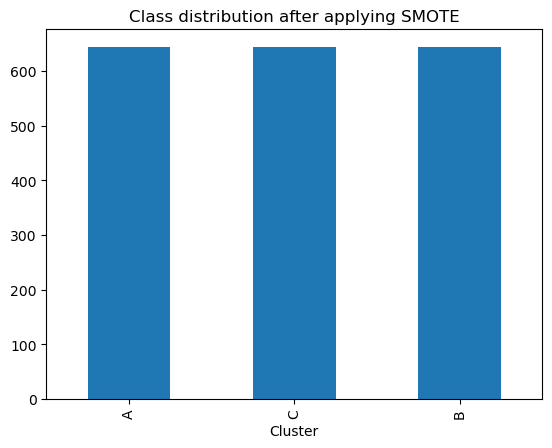

In [152]:
#Before and after SMOTE, print later. 
pd.Series(y_train).value_counts().plot(kind='bar', title='Class distribution before SMOTE', xlabel='Cluster')
pd.Series(y_resampled).value_counts().plot(kind='bar', title='Class distribution after applying SMOTE', xlabel='Cluster')



## Baseline - Dummy Classifier
- Makes predictions that ignore input features

In [228]:
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
dummy_clf = DummyClassifier(strategy="stratified")

scores_f1 = cross_val_score(dummy_clf, X_train, y_train, cv = 5, scoring="f1_macro")
scores_acc = cross_val_score(dummy_clf, X_train, y_train, cv = 5)
print("Baseline Cross validation")
print("%0.3f f1_macro with a standard deviation of %0.3f" % (scores_f1.mean(), scores_f1.std()))
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores_acc.mean(), scores_acc.std()))
print()

dummy_clf.fit(X_train, y_train)
predictions= dummy_clf.predict(X_test)
f1 = f1_score(y_test, predictions, average="macro")
accuracy = accuracy_score(y_test, predictions)

print("Test results")
print("F1 score:", f1)
print("Accuracy:", accuracy)




Baseline Cross validation
0.340 f1_macro with a standard deviation of 0.027
0.455 accuracy with a standard deviation of 0.020

Test results
F1 score: 0.3319341563786008
Accuracy: 0.4463667820069204


## Random Forest
- With Random search, Gridsearch and 5-fold cross validation
- Using SMOTE

In [ ]:
#Code for confusion matrix visual, rerun above code first
cm = confusion_matrix(y_test, y_pred) #Edit this into Y TRUE, Y PREDICTED
labels = ['Cluster A', 'Cluster B', 'Cluster C']  

# Create a heatmap with the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Set the axis labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Display the plot
plt.show()


In [205]:
#Baseline non-SMOTE
modelRF = RandomForestClassifier(random_state=1)

scores_f1 = cross_val_score(modelRF, X_train, y_train, cv = 5, scoring="f1_macro")
scores_acc = cross_val_score(modelRF, X_train, y_train, cv = 5)
print("Non-SMOTE LR Score")
print("%0.3f f1_macro with a standard deviation of %0.3f" % (scores_f1.mean(), scores_f1.std()))
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores_acc.mean(), scores_acc.std()))
print()

#Baseline SMOTE
modelRF = RandomForestClassifier(random_state=1)

scores_f1 = cross_val_score(modelRF, X_resampled, y_resampled, cv = 5, scoring="f1_macro")
scores_acc = cross_val_score(modelRF, X_resampled, y_resampled, cv = 5)

print("SMOTE")
print("%0.3f f1_macro with a standard deviation of %0.3f" % (scores_f1.mean(), scores_f1.std()))
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores_acc.mean(), scores_acc.std()))

Non-SMOTE LR Score
0.380 f1_macro with a standard deviation of 0.022
0.548 accuracy with a standard deviation of 0.030

SMOTE
0.739 f1_macro with a standard deviation of 0.007
0.740 accuracy with a standard deviation of 0.006


In [239]:
#Final model Non-SMOTE
modelRF = RandomForestClassifier(random_state=1 ,criterion = 'gini', max_depth = 20, max_features = None, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 500) #Fill in parameters

modelRF.fit(X_train, y_train)
predictions1 = modelRF.predict(X_test)

f1 = f1_score(y_test, predictions, average="macro")
accuracy = accuracy_score(y_test, predictions)

print("Test results Non-SMOTE")
print("F1 score:", f1)
print("Accuracy:", accuracy)
print()

#Final model SMOTE
modelRFx = RandomForestClassifier(random_state=1 ,criterion = 'entropy', max_depth = 30, max_features = 'log2', min_samples_leaf = 1, min_samples_split = 3, n_estimators = 500) #Fill in parameters
modelRFx.fit(X_resampled, y_resampled)
predictions = modelRFx.predict(X_test)

f1 = f1_score(y_test, predictions, average="macro")
accuracy = accuracy_score(y_test, predictions)

print("Test results SMOTE")
print("F1 score:", f1)
print("Accuracy:", accuracy)

Test results Non-SMOTE
F1 score: 0.41313252030581915
Accuracy: 0.5017301038062284

Test results SMOTE
F1 score: 0.3700947045484861
Accuracy: 0.5294117647058824


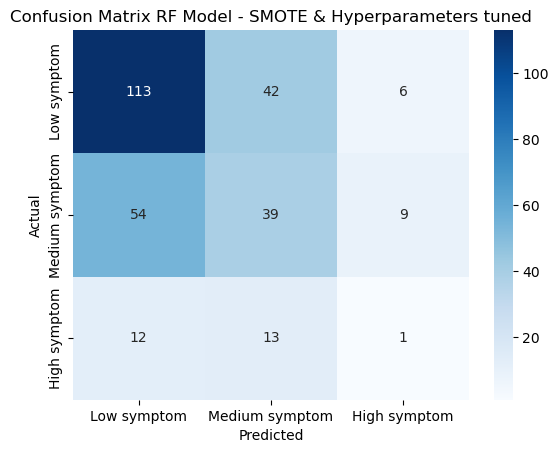

In [242]:
labels = ['Low symptom', 'Medium symptom', 'High symptom']  

#cm_rf = confusion_matrix(y_test, predictions1) #For non-smote
cm_rf = confusion_matrix(y_test, predictions) #For smote

# Create a heatmap with the confusion matrix
sns.heatmap(cm_rf , annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Set the axis labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix RF Model - SMOTE & Hyperparameters tuned')

# Display the plot
plt.show()

#### Parameter tuning

In [207]:
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'f1_macro': make_scorer(f1_score, average='macro')
}

In [217]:
param_grid = {'n_estimators': [100, 250, 500], 
              'max_features': ['log2', None], 
              'criterion': ['entropy', 'gini'], 
              'min_samples_split': [3, 5], 
              'min_samples_leaf': [1, 3, 5], 
              'max_depth': [None, 20, 30]}

In [219]:
grid = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=5, refit="f1_macro", verbose=1, scoring= scorers)
grid.fit(X_resampled, y_resampled) #SMOTE
#grid.fit(X_train, y_train) #Non-SMOTE

print(grid.best_params_)
cv_results = pd.DataFrame(grid.cv_results_)
cv_results.sort_values('rank_test_f1_macro').head(5)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
{'criterion': 'entropy', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 500}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
74       0.992458      0.012537         0.042382        0.000765   
73       0.493372      0.002090         0.022832        0.000763   
2        1.061258      0.056411         0.045022        0.002108   
1        0.555939      0.020816         0.025834        0.001506   
38       1.073763      0.025005         0.045579        0.002356   

   param_criterion param_max_depth param_max_features param_min_samples_leaf  \
74         entropy              30               log2                      1   
73         entropy              30               log2                      1   
2          entropy            None               log2                      1   
1          entropy            None               log2                      1   
38         entropy              20               log2                      1   

   param_min_samples_split param_n_estimators  \
74                       3                500   
73                       3                250   
2                        3                500   
1                        3                250   
38                       3                500   

                                               params  split0_test_accuracy  \
74  {'criterion': 'entropy', 'max_depth': 30, 'max...              0.775194   
73  {'criterion': 'entropy', 'max_depth': 30, 'max...              0.767442   
2   {'criterion': 'entropy', 'max_depth': None, 'm...              0.767442   
1   {'criterion': 'entropy', 'max_depth': None, 'm...              0.764858   
38  {'criterion': 'entropy', 'max_depth': 20, 'max...              0.759690   

    split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
74              0.733850              0.746114              0.738342   
73              0.739018              0.740933              0.738342   
2               0.731266              0.746114              0.738342   
1               0.736434              0.740933              0.735751   
38              0.739018              0.740933              0.738342   

    split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
74              0.756477            0.749995           0.014755   
73              0.761658            0.749479           0.012470   
2               0.756477            0.747928           0.012858   
1               0.761658            0.747927           0.012684   
38              0.751295            0.745856           0.008348   

    rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
74                   1              0.772950              0.728183   
73                   2              0.765308              0.733504   
2                    3              0.764983              0.725978   
1                    4              0.762621              0.731289   
38                   5              0.757438              0.733504   

    split2_test_f1_macro  split3_test_f1_macro  split4_test_f1_macro  \
74              0.747745              0.740998              0.755795   
73              0.741607              0.741428              0.760232   
2               0.747745              0.740998              0.755795   
1               0.741607              0.738879              0.760518   
38              0.742431              0.740593              0.751399   

    mean_test_f1_macro  std_test_f1_macro  rank_test_f1_macro  
74            0.749134           0.014958                   1  
73            0.748416           0.012186                   2  
2             0.747100           0.013261                   3  
1             0.746983           0.012399                   4  
38            0.745073           0.008412                   5

In [218]:
grid = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=5, refit="f1_macro", verbose=1, scoring= scorers)
#grid.fit(X_resampled, y_resampled) #SMOTE
grid.fit(X_train, y_train) #Non-SMOTE

print(grid.best_params_)
cv_results = pd.DataFrame(grid.cv_results_)
cv_results.sort_values('rank_test_f1_macro').head(5)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
{'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
167       1.239308      0.057675         0.032592        0.002939   
1         0.375640      0.044151         0.017616        0.000817   
73        0.377611      0.021255         0.018925        0.002675   
180       0.140246      0.003455         0.009220        0.000391   
108       0.150323      0.004160         0.010057        0.000812   

    param_criterion param_max_depth param_max_features param_min_samples_leaf  \
167            gini              20               None                      1   
1           entropy            None               log2                      1   
73          entropy              30               log2                      1   
180            gini              30               log2                      1   
108            gini            None               log2                      1   

    param_min_samples_split param_n_estimators  \
167                       5                500   
1                         3                250   
73                        3                250   
180                       3                100   
108                       3                100   

                                                params  split0_test_accuracy  \
167  {'criterion': 'gini', 'max_depth': 20, 'max_fe...              0.556034   
1    {'criterion': 'entropy', 'max_depth': None, 'm...              0.564655   
73   {'criterion': 'entropy', 'max_depth': 30, 'max...              0.564655   
180  {'criterion': 'gini', 'max_depth': 30, 'max_fe...              0.547414   
108  {'criterion': 'gini', 'max_depth': None, 'max_...              0.547414   

     split1_test_accuracy  split2_test_accuracy  split3_test_accuracy  \
167              0.554113              0.562771              0.545455   
1                0.536797              0.610390              0.532468   
73               0.536797              0.610390              0.532468   
180              0.510823              0.619048              0.541126   
108              0.510823              0.619048              0.541126   

     split4_test_accuracy  mean_test_accuracy  std_test_accuracy  \
167              0.562771            0.556229           0.006422   
1                0.567100            0.562282           0.027862   
73               0.567100            0.562282           0.027862   
180              0.571429            0.557968           0.036138   
108              0.571429            0.557968           0.036138   

     rank_test_accuracy  split0_test_f1_macro  split1_test_f1_macro  \
167                 136              0.366276              0.385812   
1                   111              0.371885              0.395019   
73                  111              0.371885              0.395019   
180                 125              0.361427              0.354396   
108                 125              0.361427              0.354396   

     split2_test_f1_macro  split3_test_f1_macro  split4_test_f1_macro  \
167              0.410302              0.414525              0.404831   
1                0.418457              0.376082              0.413199   
73               0.418457              0.376082              0.413199   
180              0.456398              0.381041              0.421347   
108              0.456398              0.381041              0.421347   

     mean_test_f1_macro  std_test_f1_macro  rank_test_f1_macro  
167            0.396349           0.017958                   1  
1              0.394928           0.018834                   2  
73             0.394928           0.018834                   2  
180            0.394922           0.038560                   4  
108            0.394922           0.038560                   4

#### Analysing Feature Importance

In [225]:
clf = RandomForestClassifier(random_state=1 ,criterion = 'gini', max_depth = 20, max_features = None, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 500) #Fill in parameters
clf.fit(X_train, y_train)
from sklearn.inspection import permutation_importance
r = permutation_importance(clf, X_train, y_train,
                           n_repeats=50,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{pred_df.columns[i]:<8} "
              f"{ r.importances_mean[i]:.3f}"
              f" +/- { r.importances_std[i]:.3f}")

Age_diagnosis_cat 0.267 +/- 0.010
alcoholuse 0.242 +/- 0.013
stage_tnm 0.164 +/- 0.008
clusters 0.099 +/- 0.005
education 0.071 +/- 0.005
comorbidities 0.054 +/- 0.004
smoking  0.045 +/- 0.005
systemic_1.0 0.038 +/- 0.004
sex_1    0.026 +/- 0.003
surgery_0.0 0.020 +/- 0.003
systemic_0.0 0.016 +/- 0.002
partner_1.0 0.015 +/- 0.002
surgery_1.0 0.014 +/- 0.002
partner_2.0 0.012 +/- 0.002
radiotherapy_0.0 0.009 +/- 0.001
tumortype_6.0 0.005 +/- 0.001
radiotherapy_Question not asked 0.004 +/- 0.001
tumortype_7.0 0.004 +/- 0.001
bmi      0.003 +/- 0.001
tumortype_9.0 0.002 +/- 0.001
tumortype_5.0 0.002 +/- 0.001
partner_Question not asked 0.001 +/- 0.001


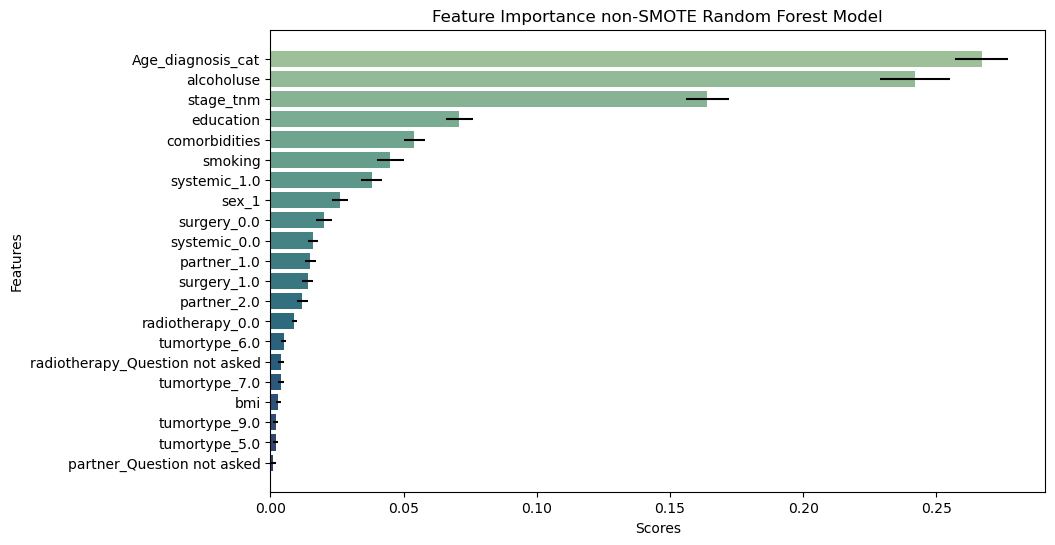

In [252]:
import matplotlib.pyplot as plt
import seaborn as sns

features = [
    "Age_diagnosis_cat", "alcoholuse", "stage_tnm", "education", "comorbidities",
    "smoking", "systemic_1.0", "sex_1", "surgery_0.0", "systemic_0.0", "partner_1.0",
    "surgery_1.0", "partner_2.0", "radiotherapy_0.0", "tumortype_6.0", "radiotherapy_Question not asked",
    "tumortype_7.0", "bmi", "tumortype_9.0", "tumortype_5.0", "partner_Question not asked"
]

scores = [
    0.267, 0.242, 0.164, 0.071, 0.054, 0.045, 0.038, 0.026, 0.020,
    0.016, 0.015, 0.014, 0.012, 0.009, 0.005, 0.004, 0.004, 0.003, 0.002,
    0.002, 0.001
]

std_devs = [
    0.010, 0.013, 0.008, 0.005, 0.004, 0.005, 0.004, 0.003, 0.003,
    0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
    0.001, 0.001
]

# Create a DataFrame from the features, scores, and standard deviations
data = {
    "Features": features,
    "Scores": scores,
    "Standard Deviations": std_devs
}
df = pd.DataFrame(data)

# Plot the bar plot with standard deviations
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="Scores", y="Features", palette="crest")

# Add error bars for standard deviations
plt.errorbar(df["Scores"], df["Features"], xerr=df["Standard Deviations"], fmt='none', ecolor='black')

# Set the labels and title
plt.xlabel('Scores')
plt.ylabel('Features')
plt.title('Feature Importance non-SMOTE Random Forest Model')

# Show the plot
plt.show()

## Logistic Regression

In [194]:
#Baseline non-SMOTE
modelLR = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2500, random_state=1)

scores_f1 = cross_val_score(modelLR, X_train, y_train, cv = 5, scoring="f1_macro")
scores_acc = cross_val_score(modelLR, X_train, y_train, cv = 5)
print("Non-SMOTE LR Score")
print("%0.3f f1_macro with a standard deviation of %0.3f" % (scores_f1.mean(), scores_f1.std()))
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores_acc.mean(), scores_acc.std()))
print()

#Baseline SMOTE
modelLR = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2500, random_state=1)

scores_f1 = cross_val_score(modelLR, X_resampled, y_resampled, cv = 5, scoring="f1_macro")
scores_acc = cross_val_score(modelLR, X_resampled, y_resampled, cv = 5)

print("SMOTE")
print("%0.3f f1_macro with a standard deviation of %0.3f" % (scores_f1.mean(), scores_f1.std()))
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores_acc.mean(), scores_acc.std()))

Non-SMOTE LR Score
0.387 f1_macro with a standard deviation of 0.015
0.589 accuracy with a standard deviation of 0.023

SMOTE
0.544 f1_macro with a standard deviation of 0.015
0.545 accuracy with a standard deviation of 0.016


In [233]:
#Final model Non-SMOTE
modelLR = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2500, random_state=1)

modelLR.fit(X_train, y_train)
predictions1 = modelLR.predict(X_test)

f1 = f1_score(y_test, predictions, average="macro")
accuracy = accuracy_score(y_test, predictions)

print("Test results Non-SMOTE")
print("F1 score:", f1)
print("Accuracy:", accuracy)
print()

#Final model SMOTE
modelLRx = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2500, random_state=1)
modelLRx.fit(X_resampled, y_resampled)
predictions = modelLRx.predict(X_test)

f1 = f1_score(y_test, predictions, average="macro")
accuracy = accuracy_score(y_test, predictions)

print("Test results SMOTE")
print("F1 score:", f1)
print("Accuracy:", accuracy)

Test results Non-SMOTE
F1 score: 0.3700947045484861
Accuracy: 0.5294117647058824

Test results SMOTE
F1 score: 0.41313252030581915
Accuracy: 0.5017301038062284


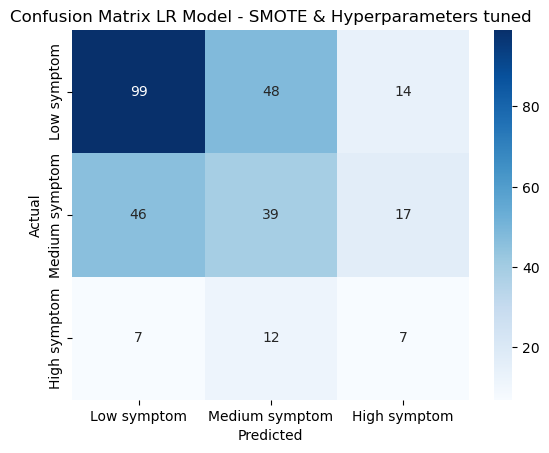

In [236]:
labels = ['Low symptom', 'Medium symptom', 'High symptom']  
cm_log = confusion_matrix(y_test, predictions)

# Create a heatmap with the confusion matrix
sns.heatmap(cm_log , annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Set the axis labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix LR Model - SMOTE & Hyperparameters tuned')

# Display the plot
plt.show()

In [199]:
from sklearn.inspection import permutation_importance
r = permutation_importance(modelLR, X_train, y_train,
                           n_repeats=50,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{pred_df.columns[i]:<8} "
              f"{ r.importances_mean[i]:.3f}"
              f" +/- { r.importances_std[i]:.3f}")

systemic_1.0 0.108 +/- 0.009
partner_2.0 0.083 +/- 0.008
radiotherapy_1.0 0.062 +/- 0.007
tumortype_8.0 0.062 +/- 0.007
alcoholuse 0.056 +/- 0.011
bmi      0.054 +/- 0.009
surgery_1.0 0.053 +/- 0.007
tumortype_6.0 0.049 +/- 0.008
sex_1    0.049 +/- 0.007
tumortype_9.0 0.041 +/- 0.008
systemic_0.0 0.030 +/- 0.007
partner_1.0 0.026 +/- 0.006
radiotherapy_Question not asked 0.022 +/- 0.009
tumortype_7.0 0.018 +/- 0.004
tumortype_5.0 0.014 +/- 0.004


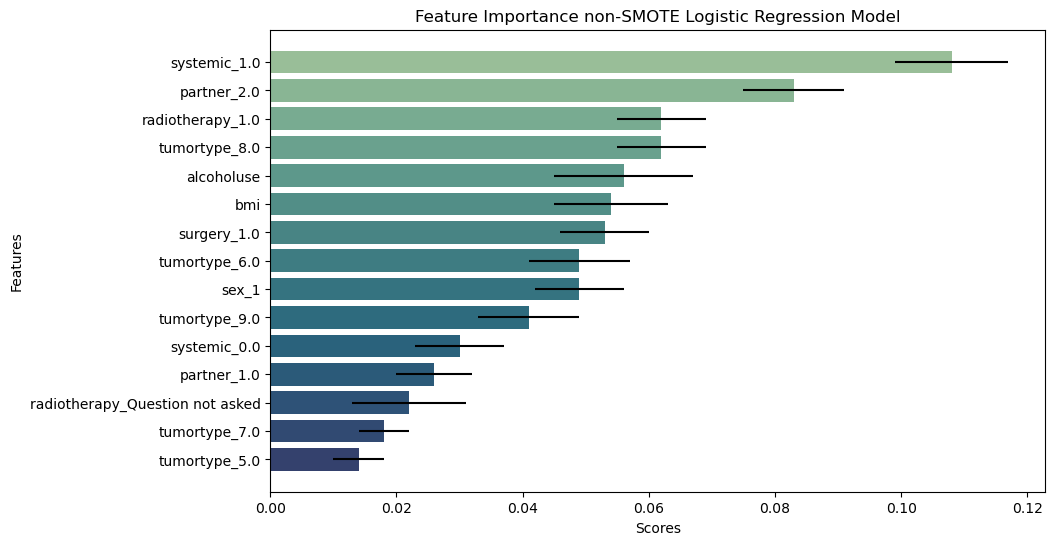

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns

features = [
    "systemic_1.0", "partner_2.0", "radiotherapy_1.0", "tumortype_8.0", "alcoholuse", "bmi",
    "surgery_1.0", "tumortype_6.0", "sex_1", "tumortype_9.0", "systemic_0.0", "partner_1.0",
    "radiotherapy_Question not asked", "tumortype_7.0", "tumortype_5.0"
]

scores = [
    0.108, 0.083, 0.062, 0.062, 0.056, 0.054, 0.053, 0.049, 0.049, 0.041, 0.030, 0.026, 0.022, 0.018, 0.014
]

std_devs = [
    0.009, 0.008, 0.007, 0.007, 0.011, 0.009, 0.007, 0.008, 0.007, 0.008, 0.007, 0.006, 0.009, 0.004, 0.004
]

# Create a DataFrame from the features, scores, and standard deviations
data = {
    "Features": features,
    "Scores": scores,
    "Standard Deviations": std_devs
}
df = pd.DataFrame(data)

# Plot the bar plot with standard deviations
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="Scores", y="Features", palette="crest")

# Add error bars for standard deviations
plt.errorbar(df["Scores"], df["Features"], xerr=df["Standard Deviations"], fmt='none', ecolor='black')

# Set the labels and title
plt.xlabel('Scores')
plt.ylabel('Features')
plt.title('Feature Importance non-SMOTE Logistic Regression Model')

# Show the plot
plt.show()


## XGBoost

In [164]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_train)
y_trainXGB = label_encoder.transform(y_train)
y_trainXGB_SMOTE = label_encoder.transform(y_resampled)

label_encoder = label_encoder.fit(y_test)
y_testXGB = label_encoder.transform(y_test)

In [165]:
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score

In [190]:
#Baseline non-SMOTE
modelxgb = XGBClassifier(random_state = 1)

scores_f1 = cross_val_score(modelxgb, X_train, y_trainXGB, cv = 5, scoring="f1_macro")
scores_acc = cross_val_score(modelxgb, X_train, y_trainXGB, cv = 5)
print("Non-SMOTE")
print("%0.3f f1_macro with a standard deviation of %0.3f" % (scores_f1.mean(), scores_f1.std()))
print("%0.3f f1_macro with a standard deviation of %0.3f" % (scores_acc.mean(), scores_acc.std()))
print()

#Baseline SMOTE
modelxgb = XGBClassifier(random_state = 1)

scores_f1 = cross_val_score(modelxgb, X_resampled, y_trainXGB_SMOTE, cv = 5, scoring="f1_macro")
scores_acc = cross_val_score(modelxgb, X_resampled, y_trainXGB_SMOTE, cv = 5)

print("SMOTE")
print("%0.3f f1_macro with a standard deviation of %0.3f" % (scores_f1.mean(), scores_f1.std()))
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores_acc.mean(), scores_acc.std()))

Non-SMOTE
0.396 f1_macro with a standard deviation of 0.045
0.534 f1_macro with a standard deviation of 0.034

SMOTE
0.689 f1_macro with a standard deviation of 0.012
0.691 accuracy with a standard deviation of 0.011


In [188]:
#Non-SMOTE Hyperparameter Tuned 
modelxgb = XGBClassifier(colsample_bytree = 1.0, learning_rate = 0.2, max_depth = 4, n_estimators = 100, reg_alpha = 0.3, reg_lambda = 0.75, subsample = 1.0, random_state = 1)

scores_f1 = cross_val_score(modelxgb, X_train, y_trainXGB, cv = 5, scoring="f1_macro")
scores_acc = cross_val_score(modelxgb, X_train, y_trainXGB, cv = 5)

print("Non-SMOTE")
print("%0.3f f1_macro with a standard deviation of %0.4f" % (scores_f1.mean(), scores_f1.std()))
print("%0.3f accuracy with a standard deviation of %0.4f" % (scores_acc.mean(), scores_acc.std()))
print()

#SMOTE Hyperparameter Tuned 
modelxgb = XGBClassifier(colsample_bylevel= 0.5,  colsample_bytree = 1.0, learning_rate = 0.1, max_depth = 12, n_estimators = 100, reg_alpha = 0.1, reg_lambda = 0.1, subsample = 0.8, 
                         random_state = 1)

scores_f1 = cross_val_score(modelxgb, X_resampled, y_trainXGB_SMOTE, cv = 5, scoring="f1_macro")
scores_acc = cross_val_score(modelxgb, X_resampled, y_trainXGB_SMOTE, cv = 5)

print("SMOTE")
print("%0.3f f1_macro with a standard deviation of %0.4f" % (scores_f1.mean(), scores_f1.std()))
print("%0.3f accuracy with a standard deviation of %0.4f" % (scores_acc.mean(), scores_acc.std()))

Non-SMOTE
0.393 f1_macro with a standard deviation of 0.0266
0.561 accuracy with a standard deviation of 0.0168

SMOTE
0.720 f1_macro with a standard deviation of 0.0082
0.722 accuracy with a standard deviation of 0.0079


In [243]:
#Final model Non-SMOTE
modelxgb_final = XGBClassifier(colsample_bytree = 1.0, learning_rate = 0.2, max_depth = 4, n_estimators = 100, reg_alpha = 0.3, reg_lambda = 0.75, subsample = 1.0, random_state = 1)

modelxgb_final.fit(X_train, y_trainXGB)
predictionsXG1 = modelxgb_final.predict(X_test)

f1 = f1_score(y_testXGB, predictionsXG1, average="macro")
accuracy = accuracy_score(y_testXGB, predictionsXG1)

print("Test results Non-SMOTE")
print("F1 score:", f1)
print("Accuracy:", accuracy)
print()

#Final model SMOTE
modelxgb_final = XGBClassifier(colsample_bylevel= 0.5,  colsample_bytree = 1.0, learning_rate = 0.05, max_depth = 8, n_estimators = 100, reg_alpha = 0.1, reg_lambda = 0.1, subsample = 0.8, 
                         random_state = 1)

modelxgb_final.fit(X_resampled, y_trainXGB_SMOTE)
predictionsXG2 = modelxgb_final.predict(X_test)

f1 = f1_score(y_testXGB, predictionsXG2, average="macro")
accuracy = accuracy_score(y_testXGB, predictionsXG2)

print("Test results SMOTE")
print("F1 score:", f1)
print("Accuracy:", accuracy)



Test results Non-SMOTE
F1 score: 0.39014436146164194
Accuracy: 0.5432525951557093

Test results SMOTE
F1 score: 0.3573619385976365
Accuracy: 0.5086505190311419


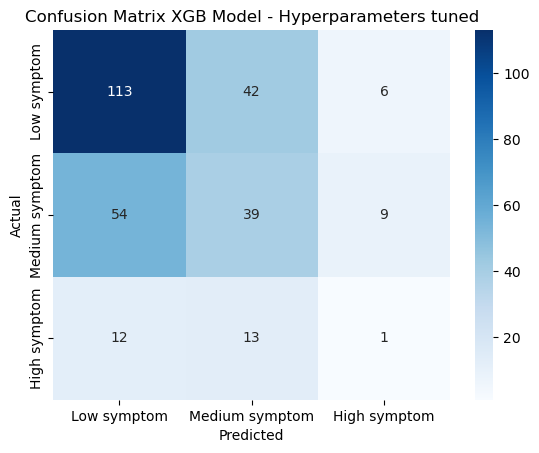

In [250]:
labels = ['Low symptom', 'Medium symptom', 'High symptom']  

cm_xg = confusion_matrix(y_testXGB, predictionsXG1) #For non-smote
#cm_xg = confusion_matrix(y_testXGB, predictionsXG2) #For smote

# Create a heatmap with the confusion matrix
sns.heatmap(cm_rf , annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Set the axis labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix XGB Model - Hyperparameters tuned')

# Display the plot
plt.show()

#### Grid Search for optimal hyperparameters

In [ ]:
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'f1_macro': make_scorer(f1_score, average='macro')
}

In [185]:
param_grid = [
    {'subsample': [0.8, 1.0], 'n_estimators': [100, 200], 
     'max_depth': [4, 6, 8], 'learning_rate': [0.1, 0.2],
     'colsample_bytree': [0.75, 1.0], 'reg_alpha':[0.1, 0.3], 'reg_lambda': [1.0, 0.75] }]

#grid_search = GridSearchCV(modelxgb, param_grid, cv=5, verbose=1, scoring="f1_macro")
grid_search = GridSearchCV(modelxgb, param_grid, cv=5, verbose=1, scoring=scorers, refit='accuracy')


In [ ]:
grid_search.fit(X_train, y_trainXGB)
#grid_search.fit(X_resampled, y_trainXGB_SMOTE)

In [187]:
#For non-SMOTE
grid_search.fit(X_train, y_trainXGB)
print(grid_search.best_params_)
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.sort_values('rank_test_score').head(5)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 0.3, 'reg_lambda': 0.75, 'subsample': 1.0}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
151       0.103599      0.004176         0.004600        0.000490   
119       0.138599      0.005314         0.005000        0.000001   
8         0.185693      0.013674         0.003999        0.000002   
69        0.126800      0.003763         0.004399        0.000800   
56        0.228647      0.019225         0.004799        0.000399   

    param_colsample_bytree param_learning_rate param_max_depth  \
151                    1.0                 0.2               4   
119                    1.0                 0.1               6   
8                     0.75                 0.1               4   
69                    0.75                 0.2               6   
56                    0.75                 0.2               4   

    param_n_estimators param_reg_alpha param_reg_lambda param_subsample  \
151                100             0.3             0.75             1.0   
119                100             0.3             0.75             1.0   
8                  200             0.1              1.0             0.8   
69                 100             0.3              1.0             1.0   
56                 200             0.1              1.0             0.8   

                                                params  split0_test_score  \
151  {'colsample_bytree': 1.0, 'learning_rate': 0.2...           0.472060   
119  {'colsample_bytree': 1.0, 'learning_rate': 0.1...           0.468484   
8    {'colsample_bytree': 0.75, 'learning_rate': 0....           0.452640   
69   {'colsample_bytree': 0.75, 'learning_rate': 0....           0.492371   
56   {'colsample_bytree': 0.75, 'learning_rate': 0....           0.448081   

     split1_test_score  split2_test_score  split3_test_score  \
151           0.372500           0.437194           0.456217   
119           0.401150           0.393209           0.433889   
8             0.459289           0.391191           0.403182   
69            0.407190           0.354913           0.432960   
56            0.442740           0.381433           0.392440   

     split4_test_score  mean_test_score  std_test_score  rank_test_score  
151           0.394841         0.426562        0.037394                1  
119           0.420845         0.423515        0.026667                2  
8             0.403818         0.422024        0.028154                3  
69            0.417340         0.420955        0.044291                4  
56            0.435981         0.420135        0.027597                5

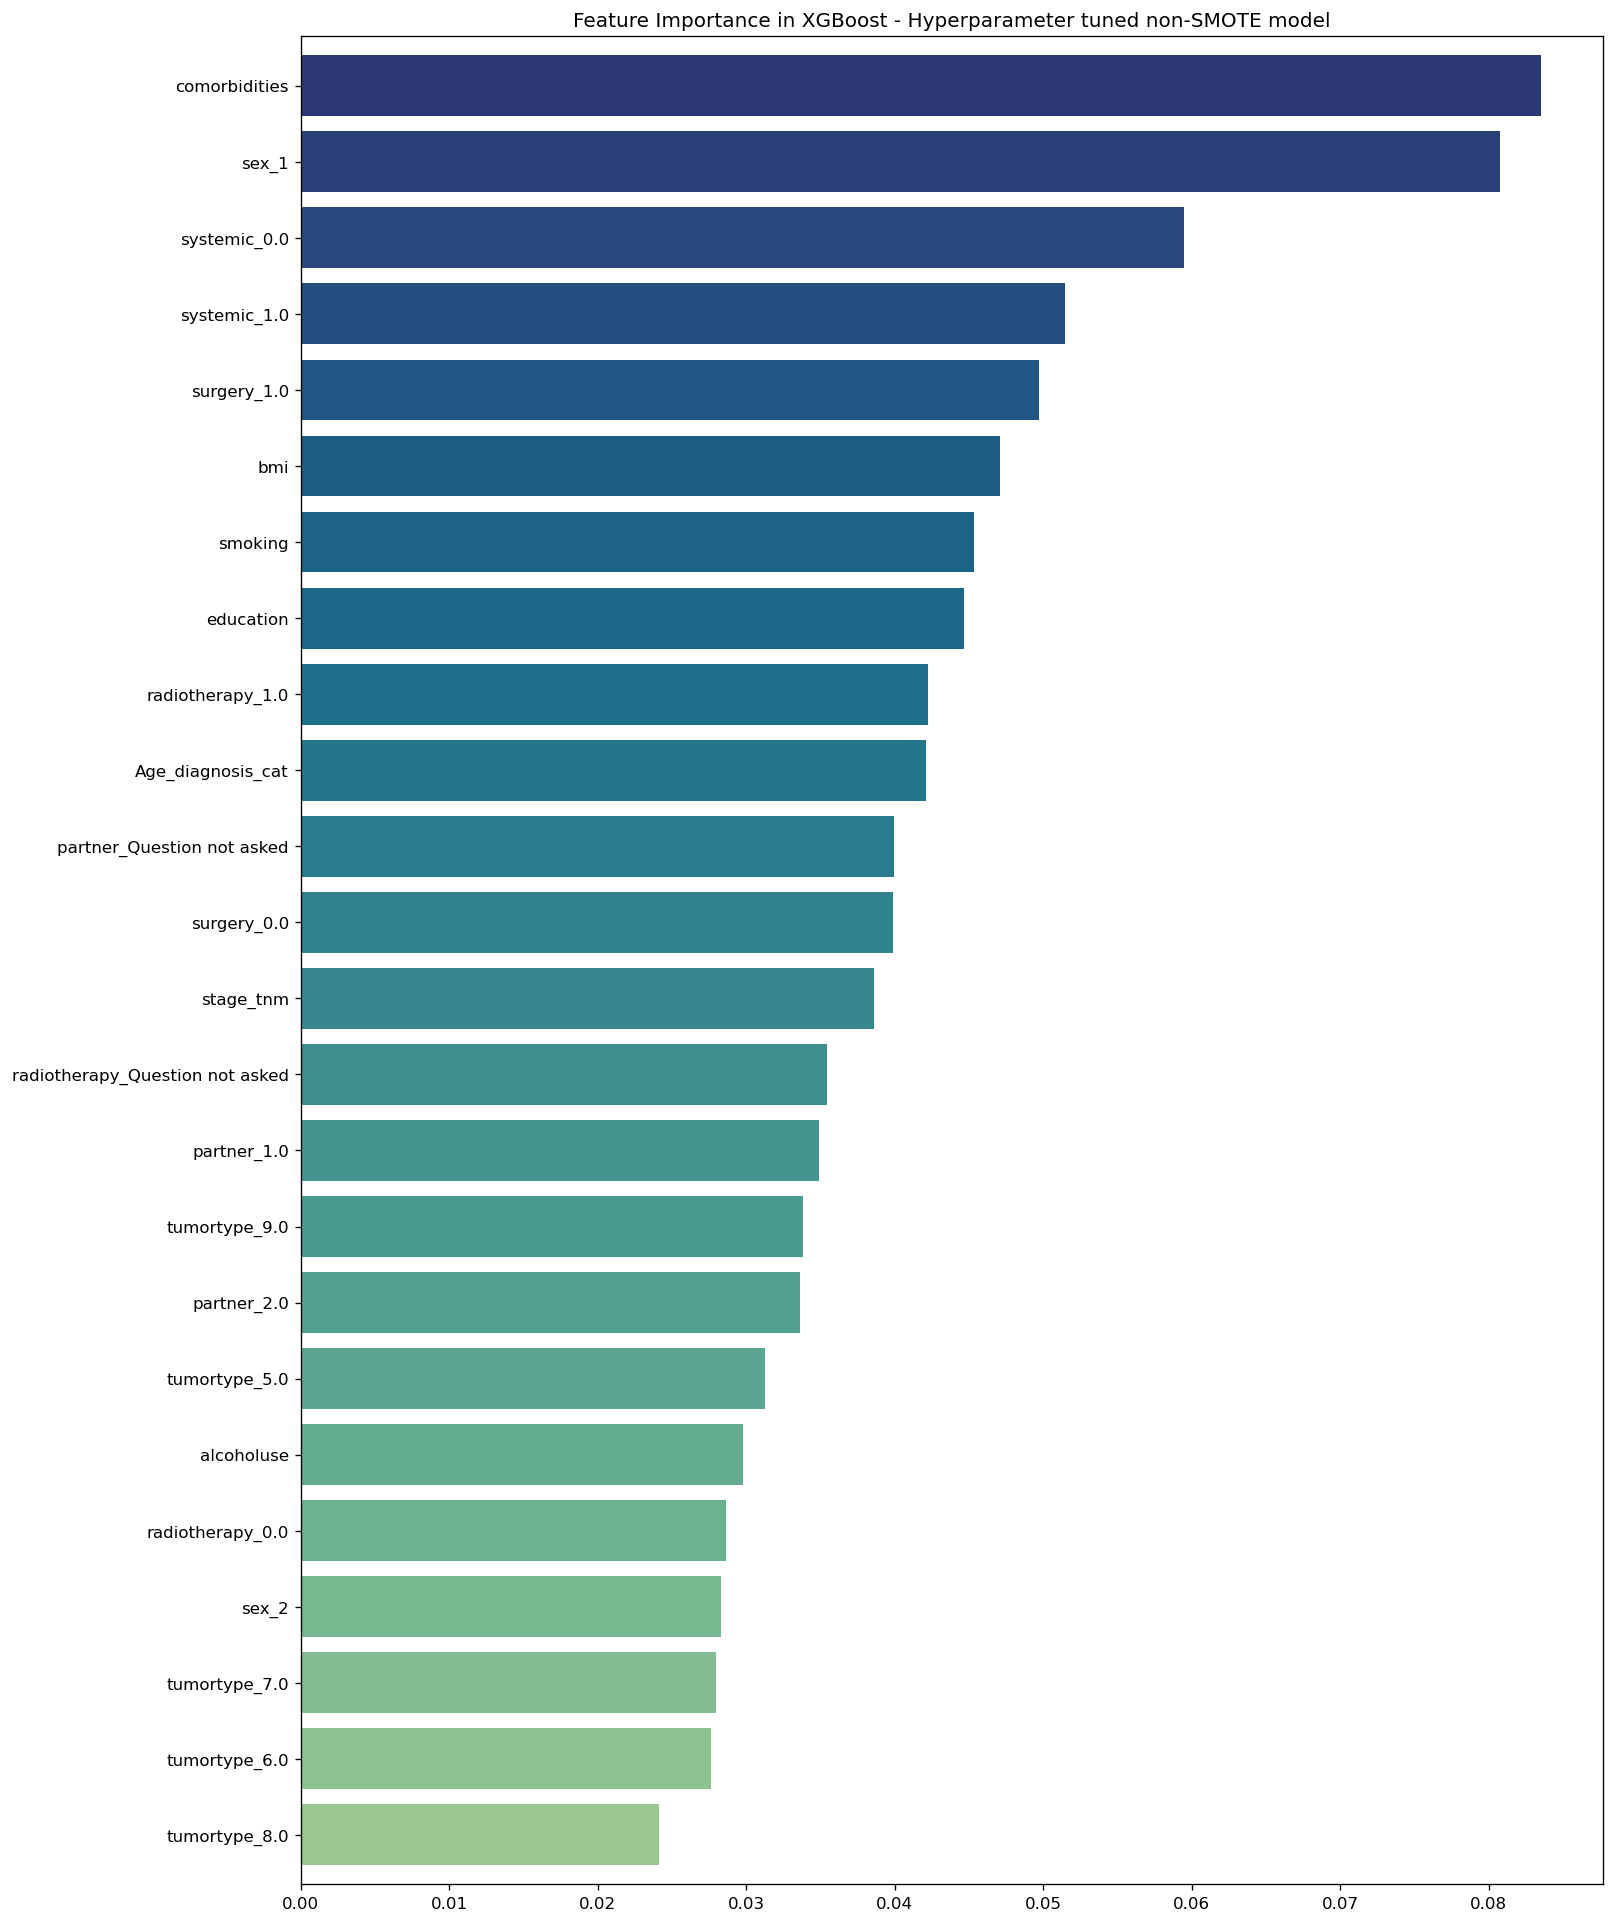

In [193]:
Feature_Imp = grid_search.best_estimator_.feature_importances_
Feature_Imp_sorted_series = pd.Series(Feature_Imp,X.columns).sort_values(ascending=True)

# Plot horizaontal bar plot
plt.figure(figsize=(14,20), dpi=120)
palette = sns.color_palette("crest", len(X.columns)).as_hex()
ax = Feature_Imp_sorted_series.plot.barh(width=0.8 ,color=palette)
ax.set_title('Feature Importance in XGBoost - Hyperparameter tuned non-SMOTE model')
plt.show()

### Junk

In [ ]:
test_model_xgb.fit(X_train, y_trainXGB)
predictions = test_model_xgb.predict(X_test)


In [335]:
dtrain = xgb.DMatrix(X_train, label=y_trainXGB)
dtrain_smote = xgb.DMatrix(X_resampled, label=y_trainXGB_SMOTE)
dtest = xgb.DMatrix(X_test, label=y_testXGB)


In [376]:
#Normal
num_rounds = 10000
model = xgb.train(params_1, dtrain, num_rounds)

#SMOTE
model2 = xgb.train(params_1, dtrain_smote, num_rounds)

[09:50:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators", "normalize_type", "rate_drop", "sample_type" } are not used.

[09:50:24] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[09:50:24] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[09:50:24] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=5
[09:50:24] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-gro

In [380]:
model.get_score(importance_type="total_gain")

{'education': 794.7931518554688,
 'smoking': 756.5720825195312,
 'alcoholuse': 480.83355712890625,
 'comorbidities': 1150.096923828125,
 'stage_tnm': 706.3319091796875,
 'Age_diagnosis_cat': 1686.6033935546875,
 'bmi': 261848.40625,
 'partner_1.0': 137.9084930419922,
 'partner_2.0': 161.7855682373047,
 'partner_Question not asked': 139.63328552246094,
 'tumortype_5.0': 53815.5859375,
 'tumortype_6.0': 63.53783416748047,
 'tumortype_7.0': 118.85991668701172,
 'tumortype_8.0': 109.84550476074219,
 'tumortype_9.0': 23.001907348632812,
 'radiotherapy_0.0': 43.79834747314453,
 'radiotherapy_1.0': 178.73756408691406,
 'surgery_0.0': 66.35677337646484,
 'surgery_1.0': 142.36854553222656,
 'systemic_0.0': 225.76095581054688,
 'sex_1': 361.6199645996094}

In [332]:
#NON SMOTE
from sklearn.metrics import f1_score

y_pred = model.predict(dtest)
accuracy = accuracy_score(y_testXGB, y_pred.round())
macro_f1 = f1_score(y_testXGB, y_pred.round(), average='macro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1: %.2f%%" % (macro_f1 * 100.0))

Accuracy: 56.06%
F1: 37.33%


In [337]:
#SMOTE

y_pred = model2.predict(dtest)
accuracy = accuracy_score(y_testXGB, y_pred.round())
macro_f1 = f1_score(y_testXGB, y_pred.round(), average='macro')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("F1: %.2f%%" % (macro_f1 * 100.0))

Accuracy: 50.87%
F1: 34.32%
